## Part 1: Prepare the Data

In [1]:
# Import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
# Read CSV file
df = pd.read_csv("Resources/myopia.csv")
df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


In [3]:
# Drop MYOPIC column
myopia_df = df.drop(["MYOPIC"], axis="columns")
myopia_df.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0


In [4]:
# Find any null values
for col in myopia_df.columns:
   print(f"{col}  : {myopia_df[col].isnull().sum()} null values")

AGE  : 0 null values
SPHEQ  : 0 null values
AL  : 0 null values
ACD  : 0 null values
LT  : 0 null values
VCD  : 0 null values
SPORTHR  : 0 null values
READHR  : 0 null values
COMPHR  : 0 null values
STUDYHR  : 0 null values
TVHR  : 0 null values
DIOPTERHR  : 0 null values
MOMMY  : 0 null values
DADMY  : 0 null values


In [5]:
# Find any duplicate entries
print(f"Duplicate entries: {myopia_df.duplicated().sum()}")

Duplicate entries: 0


In [6]:
# Create a scaler
scaler = StandardScaler()

# Load scaler with data, fit and transform
scaled_df = scaler.fit_transform(myopia_df)
scaled_df[0]

array([-0.42021911, -1.3639169 , -0.89286146,  0.48378402, -0.28144315,
       -1.0197916 ,  4.1506609 ,  1.69744958, -0.68931054, -0.67299591,
        0.18405806,  0.49830393,  0.98713773,  1.0032415 ])

## Part 2: Apply Dimensionality Reduction

In [7]:
# Perform dimensionality reduction with PCA
pca = PCA(n_components=0.9)
myopia_pca = pca.fit_transform(scaled_df)
pca.explained_variance_ratio_.sum()

0.9187361702915189

In [8]:
print(f"The scaled shape is {scaled_df.shape} while the PCA transformed shape is {myopia_pca.shape}, thus the number of features have been reduced from 14 to 10.")

The scaled shape is (618, 14) while the PCA transformed shape is (618, 10), thus the number of features have been reduced from 14 to 10.


In [9]:
# Further reduce the dataset with t-SNE and visually inspect the results
tsne = TSNE(learning_rate = 300, n_components=3, perplexity=55, verbose=1, n_iter=2000)
tsne_features = tsne.fit_transform(myopia_pca)

[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 618 samples in 0.002s...
[t-SNE] Computed neighbors for 618 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 618 / 618
[t-SNE] Mean sigma: 1.466166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.525696
[t-SNE] KL divergence after 2000 iterations: 2.482458


In [10]:
# Get the shape of the features after reduction
tsne_features.shape

(618, 3)

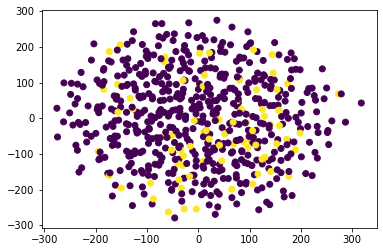

In [11]:
# Create a scatter plot of the output
plt.scatter(tsne_features[:,0],tsne_features[:,1], c=df['MYOPIC'])

## Part 3: Perform a Cluster Analysis with K-means

In [12]:
# Create elbow plot to find the best number of clusters
inertia = []
k = list(range(1,11))

for i in k:
   km = KMeans(n_clusters=i, random_state=0)
   km.fit(myopia_pca)
   inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
elbow_df = pd.DataFrame(elbow_data)
elbow_df.head()

,k,inertia
0,1,7948.905345
1,2,6794.293482
2,3,6030.627246
3,4,5665.932930
4,5,5377.262999


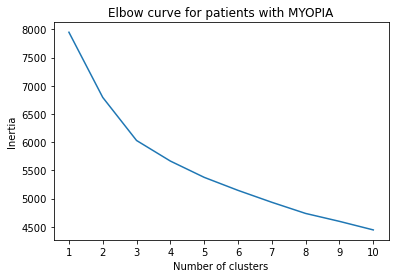

In [13]:
# Plot the elbow curve to find the best candidate
plt.plot(elbow_df['k'], elbow_df['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for patients with MYOPIA')
plt.show()

In [14]:
# Definte the clusters function
def clusters(i, j):

   # Initialise the K-Means model
   model = KMeans(n_clusters=i, random_state=0)

   # Train the model
   model.fit(j)

   # Predict clusters
   predictions = model.predict(j)

   # Add to the predicted class column
   j['class'] = model.labels_

   return j

In [15]:
# Create the dataframe from the pca array
col = []
for i in range(len(pca.components_)):
   col.append(i+1)
pca_df = pd.DataFrame(myopia_pca, columns=col)

In [16]:
# Load the dataframe with required data using the clusters function
clusters_df = clusters(3, pca_df)
clusters_df

,1,2,3,4,5,6,7,8,9,10,class
0,0.535503,1.145004,-1.385019,0.116006,-3.226691,-1.928459,-1.958892,-1.922997,0.026753,0.178144,1
1,-0.624706,-1.575786,-0.794253,1.156287,0.292256,0.349060,-0.455206,0.285332,0.689683,-0.557031,0
2,-0.933479,-0.717076,0.820150,-1.547638,0.173941,0.272783,0.025821,-0.030817,-0.431499,0.013336,1
3,0.106354,1.192475,-0.024441,1.507469,-2.356836,-0.023139,0.236418,-1.717109,-1.230785,-0.703400,1
4,-0.388503,-2.839655,-0.229767,-0.622510,0.271458,-0.928956,0.537900,-1.301787,0.279007,0.631183,0
...,...,...,...,...,...,...,...,...,...,...,...
613,-0.237547,1.146547,-1.546054,-0.248834,2.326683,-0.202403,0.084104,0.705501,-0.854993,0.736996,1
614,-0.649011,-1.796952,-0.823592,0.564878,0.134282,0.348639,-0.174354,0.252875,1.022202,-0.544105,0
615,-0.890082,-2.308005,0.268102,0.262770,0.231606,0.566061,-0.328287,-0.489877,1.822691,0.081777,0
616,-1.124000,0.451890,0.001659,-0.847089,-0.143347,-0.414353,-0.448120,0.239685,-1.592822,-1.014581,1


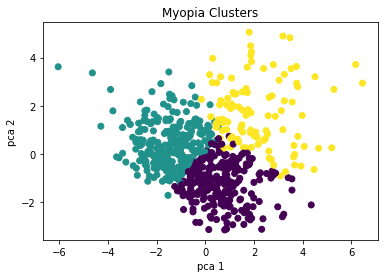

In [17]:
# Plot the clusters
plt.scatter(x=pca_df[1], y=pca_df[2], c=pca_df['class'])
plt.xlabel('pca 1')
plt.ylabel('pca 2')
plt.title('Myopia Clusters')
plt.show()

## Part 4: Make a Recommendation
Based on the findings and the visual above, it can be concluded that the patients can be clustered into 3 clusters. 